In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')
SEED = 2000

In [93]:
data = pd.read_csv("../data/clean_tweet.csv", index_col=0)
data.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [94]:
x = data.text
y = data.target

In [95]:
x_train, x_validation_test, y_train, y_validation_test = train_test_split(x,y, test_size=0.02, random_state=SEED)

In [96]:
x_train.shape

(1564120,)

In [97]:
x_validation_test.shape

(31921,)

In [98]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=SEED)

In [99]:
print(f"Train set has total {len(x_train)} with {len(x_train[y_train==0])*100/(len(x_train)*1.0)}% negative and {len(x_train[y_train==4])*100/(len(x_train)*1.0)}% positive")

Train set has total 1564120 with 50.020139119760636% negative and 0.0% positive


In [100]:
print(f"Validation set has total {len(x_validation)} with {len(x_validation[y_validation==0])*100/(len(x_validation)*1.0)}% negative and {len(x_validation[y_validation==4])*100/(len(x_validation)*1.0)}% positive")

Validation set has total 15960 with 49.454887218045116% negative and 0.0% positive


In [101]:
print(f"Test set has total {len(x_test)} with {len(x_test[y_test==0])*100/(len(x_test)*1.0)}% negative and {len(x_test[y_test==4])*100/(len(x_test)*1.0)}% positive")

Test set has total 15961 with 49.67733851262452% negative and 0.0% positive


### Baseline

The basline can be ZeroRule classifier (classifiy the majority class always). That would give an accuracy of 50.02%.

We are using the inbuild sentiment analysis available in `TextBlob` library.

In [102]:
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [103]:
textblob_result = [TextBlob(i).sentiment_assessments for i in x_validation]

In [104]:
textblob_result[0]

Sentiment(polarity=0.0, subjectivity=0.06666666666666667, assessments=[(['last'], 0.0, 0.06666666666666667, None)])

In [105]:
textblob_predictions = [0 if n.polarity < 0 else 1 for n in textblob_result]

In [106]:
type(y_validation)

pandas.core.series.Series

In [118]:
confusion_mat = confusion_matrix(y_validation, textblob_predictions, labels=[1,0])
confusion_df = pd.DataFrame(confusion_mat, index=['positive', 'negative'], columns=['predicted_positive', 'predicted_negative'])

In [119]:
print(f"Accuracy score is {accuracy_score(y_validation, textblob_predictions)*100.0}")
print("-"*80)
print("Confusion Matrix\n")
print(confusion_df)
print("-"*80)
print("Classification Report\n")
print(classification_report(y_validation, textblob_predictions))

Accuracy score is 61.83583959899749
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive                7282                 785
negative                5306                2587
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.77      0.33      0.46      7893
           1       0.58      0.90      0.71      8067

    accuracy                           0.62     15960
   macro avg       0.67      0.62      0.58     15960
weighted avg       0.67      0.62      0.58     15960



### Count vectorizer

In [120]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from time import time

In [157]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    best_guess = 0.0
    if len(x_train[y_train == 0])*1.0/len(x_train) > 0.5:
        best_guess = len(x_test[y_test==0])*1.0/len(x_test)
    else:
        best_guess = 1.0 - len(x_test[y_test==0])*1.0/len(x_test)
        
    starttime = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    endtime = time()
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Best guess accuracy is {best_guess*100.0}%")
    print(f"Accuracy for the passed model (linear regression) is {accuracy*100.0}%")
    if accuracy > best_guess:
        print(f"The passed model is more accuracte than best guess by {(accuracy-best_guess)*100.0}%")
    elif accuracy == best_guess:
        print(f"The passed model gives same accuracy as best guess, {(accuracy*100.0)}")
    else:
        print(f"The best guess accuracy is more than model accuracy by {(best_guess-accuracy)*100.0}%")
        
    print(f"The total train and test time is {endtime-starttime}")
    print("--"*40)
    return accuracy, endtime-starttime

In [158]:
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)

In [159]:
def nfeature_accuracy_checker(vectorizer = cvec, n_features=n_features, stop_words = None, ngram_range=(1,1), classifier=lr):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print(f"Validation result for {n} features")
        n_feature_accuracy, total_time = accuracy_summary(checker_pipeline, x_train, y_train, x_test, y_test)
        result.append((n,n_feature_accuracy, total_time))
    return result

In [161]:
csv = '../data/term_freq_df.csv'
term_freq_df = pd.read_csv(csv, index_col=0)
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,neg,pos,total
to,313162,252567,565729
the,257836,265998,523834
my,190775,125955,316730
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86861,281585
is,133432,111191,244623
in,115542,101160,216702
for,98999,117369,216368


In [162]:
from sklearn.feature_extraction import text
a = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [167]:
my_stop_words = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:10].index))
my_stop_words = list(my_stop_words)

In [ ]:
print("Result for Unigram without stop words\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

print("Result for Unigram with stop words\n")
feature_result_wsw = nfeature_accuracy_checker()

print("Result for Unigram with my top 10 stop words\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

In [172]:
feature_result_wsw_df = pd.DataFrame(feature_result_wsw, columns=['n_features', 'validation_accuracy', 'test_train_time'])
feature_result_wosw_df = pd.DataFrame(feature_result_wosw, columns=['n_features', 'validation_accuracy', 'test_train_time'])
feature_result_wocsw_df = pd.DataFrame(feature_result_wocsw, columns=['n_features', 'validation_accuracy', 'test_train_time'])

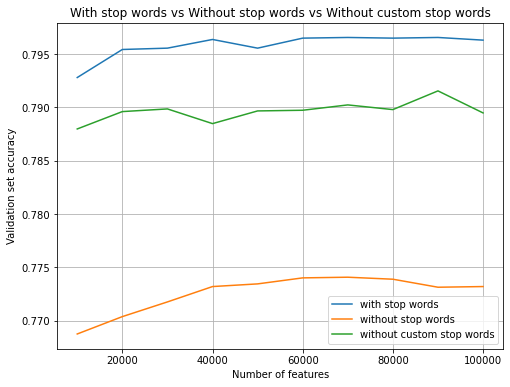

In [179]:
plt.figure(figsize=(8,6))
plt.plot(feature_result_wsw_df.n_features, feature_result_wsw_df.validation_accuracy, label='with stop words')
plt.plot(feature_result_wosw_df.n_features, feature_result_wosw_df.validation_accuracy, label='without stop words')
plt.plot(feature_result_wocsw_df.n_features, feature_result_wocsw_df.validation_accuracy, label='without custom stop words')
plt.title("With stop words vs Without stop words vs Without custom stop words")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print("Result for Bigram with stop words\n")
feature_result_bg = nfeature_accuracy_checker(ngram_range=(1,2))

print("Result for Trigram with stop words\n")
feature_result_tg = nfeature_accuracy_checker(ngram_range=(1,3))

In [183]:
feature_result_bg_df = pd.DataFrame(feature_result_bg, columns=['n_features', 'validation_accuracy', 'test_train_time'])
feature_result_tg_df = pd.DataFrame(feature_result_tg, columns=['n_features', 'validation_accuracy', 'test_train_time'])

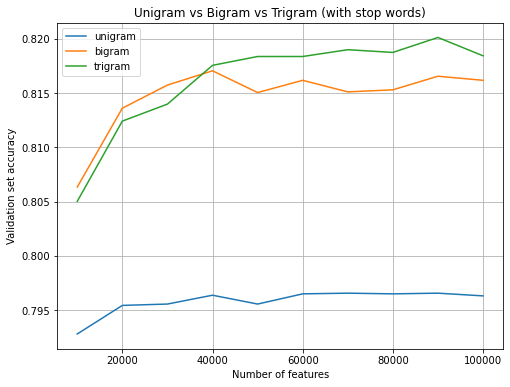

In [184]:
plt.figure(figsize=(8,6))
plt.plot(feature_result_wsw_df.n_features, feature_result_wsw_df.validation_accuracy, label='unigram')
plt.plot(feature_result_bg_df.n_features, feature_result_bg_df.validation_accuracy, label='bigram')
plt.plot(feature_result_tg_df.n_features, feature_result_tg_df.validation_accuracy, label='trigram')
plt.title("Unigram vs Bigram vs Trigram (with stop words)")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.grid(True)
plt.show()

What exactly is precision and recall?

If the class distribution is equal than accuracy might be able to give an actual prediction of the model. When the distribution is not same, then it will not.

In case of skewed distrbution, its better to look at other evalutaion metrics.

Precision  -> what proportion of data predicted as postitive actually is positive TP/(TP+FP)
Recall -> what proportion of data that actually is positive were predicted position TP/(TP+FN)
F1 -> harmonic mean of precision and recall 2*P*R/(P+R)

In [191]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    best_guess = 0.0
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        best_guess = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        best_guess = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['negative', 'positive'],
                         columns=['predicted_negative','predicted_positive'])
    print("Best guess accuracy: {0:.2f}%".format(best_guess*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > best_guess:
        print("model is {0:.2f}% more accurate than best guess accuracy".format((accuracy-best_guess)*100))
    elif accuracy == best_guess:
        print("model has the same accuracy with the best guess accuracy")
    else:
        print("model is {0:.2f}% less accurate than best guess accuracy".format((best_guess-accuracy)*100))
    print("-"*80)
    print("Confusion Matrix\n")
    print(confusion)
    print("-"*80)
    print("Classification Report\n")
    print(classification_report(y_test, y_pred, target_names=['negative','positive']))

In [192]:
%%time
tg_cvec = CountVectorizer(max_features=80000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

Best guess accuracy: 50.55%
accuracy score: 82.38%
model is 31.84% more accurate than best guess accuracy
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_negative  predicted_positive
negative                6331                1562
positive                1250                6817
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.84      0.80      0.82      7893
    positive       0.81      0.85      0.83      8067

    accuracy                           0.82     15960
   macro avg       0.82      0.82      0.82     15960
weighted avg       0.82      0.82      0.82     15960

CPU times: user 4min 24s, sys: 15.7 s, total: 4min 40s
Wall time: 3min 13s


In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [ ]:
print("Result for unigram model with TF-IDF vectorizer\n")
feature_result_tf = nfeature_accuracy_checker(vectorizer=tvec)

print("Result for bigram model with TF-IDF vectorizer\n")
feature_result_tf_bg = nfeature_accuracy_checker(vectorizer=tvec, ngram_range=(1,2))

print("Result for trigram model with TF-IDF vectorizer\n")
feature_result_tf_tg = nfeature_accuracy_checker(vectorizer=tvec, ngram_range=(1,3))

In [195]:
feature_result_tf_df = pd.DataFrame(feature_result_tf, columns=['n_features', 'validation_accuracy', 'test_train_time'])
feature_result_tf_bg_df = pd.DataFrame(feature_result_tf_bg, columns=['n_features', 'validation_accuracy', 'test_train_time'])
feature_result_tf_tg_df = pd.DataFrame(feature_result_tf_tg, columns=['n_features', 'validation_accuracy', 'test_train_time'])

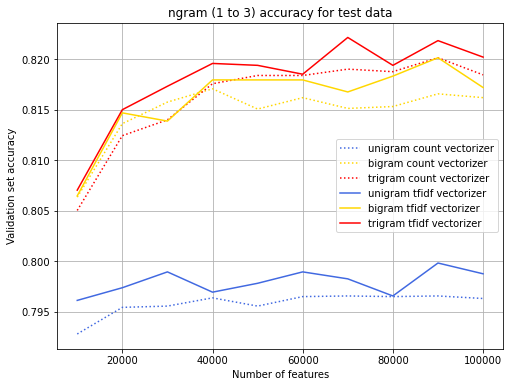

In [199]:
plt.figure(figsize=(8,6))
plt.plot(feature_result_wsw_df.n_features, feature_result_wsw_df.validation_accuracy, label='unigram count vectorizer', linestyle=':', color='royalblue')
plt.plot(feature_result_bg_df.n_features, feature_result_bg_df.validation_accuracy, label='bigram count vectorizer', linestyle=':', color='gold')
plt.plot(feature_result_tg_df.n_features, feature_result_tg_df.validation_accuracy, label='trigram count vectorizer', linestyle=':', color='red')
plt.plot(feature_result_tf_df.n_features, feature_result_tf_df.validation_accuracy, label='unigram tfidf vectorizer', color='royalblue')
plt.plot(feature_result_tf_bg_df.n_features, feature_result_tf_bg_df.validation_accuracy, label='bigram tfidf vectorizer', color='gold')
plt.plot(feature_result_tf_tg_df.n_features, feature_result_tf_tg_df.validation_accuracy, label='trigram tfidf vectorizer', color='red')
plt.title("ngram (1 to 3) accuracy for test data")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()
plt.grid(True)
plt.show()